In [1]:
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from os import path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
from tqdm.notebook import tqdm # Professional progress bar

In [2]:
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab

with open("vocab_dump.txt", "w", encoding="utf-8") as f:
    decoded = enc.decode([i for i in range(vocab_size)])
    f.write(decoded)
print(vocab_size)

50257


In [3]:
d_model = 384
n_heads = 12
d_head = 32 # changeables

vocab_size = enc.n_vocab
batch_size = 32
context_len = 128

lr = 3e-4

epochs = 10_000
eval_iters = 20
device = 'mps'
load_check_point = True
data_dir = os.path.join('../data', "openwebtext")

# Arrays to store data
step_history = []
# We need to store mean and std separately
train_history = {'mean': [], 'std': []}
val_history = {'mean': [], 'std': []}

In [4]:
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - context_len, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+context_len]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+context_len]).astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [5]:
class OneLayerTransformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, n_heads: int, d_head: int, context_len: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head 
        self.context_len = context_len
        # Embedding
        self.W_E = nn.Embedding(self.vocab_size, self.d_model)
        self.W_pos = nn.Embedding(context_len, d_model)
        self.W_Q = nn.Linear(self.d_model, self.n_heads * self.d_head, bias=False)
        self.W_K = nn.Linear(self.d_model, self.n_heads * self.d_head, bias=False)
        self.W_V = nn.Linear(self.d_model, self.n_heads * self.d_head, bias=False)
        self.W_O = nn.Linear(self.n_heads * self.d_head, self.d_model, bias=False)
        # Unembedding
        self.W_U = nn.Linear(self.d_model, self.vocab_size)

    def forward(self, x: torch.Tensor, return_all: bool = False) -> torch.Tensor:
        device = x.device
        d_head, n_heads = self.d_head, self.n_heads
        B, T = x.shape
        pos = torch.arange(T, device=device)
        x = self.W_E(x) + self.W_pos(pos)
        
        residual = x 
        # B, T, C
        q = self.W_Q(x) # (B, T, n_heads * d_head)
        k = self.W_K(x)  
        v = self.W_V(x)

        # To parallelize acros heads and batches
        q = q.view(B, T, n_heads, d_head).transpose(1, 2)
        v = v.view(B, T, n_heads, d_head).transpose(1, 2)
        k = k.view(B, T, n_heads, d_head).transpose(1, 2)
                                # B, T, n_heads, d_head -> B, T, n_heads, d_head
        scores = torch.matmul(q, k.transpose(-2, -1)) / d_head ** 0.5 # [B, n_heads, T, d_head] @ [B, n_heads, d_head, T] = B, n_heads, T, T
        mask = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        scores = scores.masked_fill(mask, float('-inf'))
        # 4. Softmax
        pattern = F.softmax(scores, dim=-1)

        z = torch.matmul(pattern, v) # [B, n_heads, T, d_head]
        z = z.transpose(1, 2).contiguous().view(B, T, -1)
        attn_out = self.W_O(z)

        hidden_state = attn_out + residual
        logits = self.W_U(hidden_state)
        if return_all:
            return logits, scores, pattern, v, z, hidden_state
        return logits 


In [6]:
model = OneLayerTransformer(
    vocab_size=vocab_size,
    d_model= d_model,
    n_heads=n_heads,
    d_head=d_head,
    context_len=context_len
)
model.to(device)

optim = optim.AdamW(model.parameters(), lr, betas=(0.9, 0.999))

# Load checkpoint if needed
if load_check_point:
    checkpoint = torch.load('one_layer_transformer.pth', map_location=device)
    model.load_state_dict(checkpoint['model'])
    if 'optimizer' in checkpoint:
        optim.load_state_dict(checkpoint['optimizer'])


In [7]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), Y.view(B*T))
            losses[k] = loss.item()
        
        # Calculate Mean and Standard Deviation
        out[split] = {
            'mean': losses.mean().item(),
            'std': losses.std().item()
        }
    model.train()
    return out

In [8]:
for epoch in tqdm(range(100), desc="Training Model"):

    if epoch % 1000 == 0 and epoch != 0 :
        stats = estimate_loss()
        step_history.append(epoch)
        train_history['mean'].append(stats['train']['mean'])
        train_history['std'].append(stats['train']['std'])
        val_history['mean'].append(stats['val']['mean'])
        val_history['std'].append(stats['val']['std'])
        # --- PLOTTING MAGIC ENDS HERE ---

        print(f"step {epoch}: val loss {stats['val']['mean']:.4f} +/- {stats['val']['std']:.4f}")

    
    xb, yb = get_batch('train')

    # Forward pass
    logits = model(xb)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T))

    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()
    # if epoch % 100 == 0:
        # print(f"step {epoch}: Loss {epoch}: {loss.item():.4f}")

Training Model:   0%|          | 0/100 [00:00<?, ?it/s]

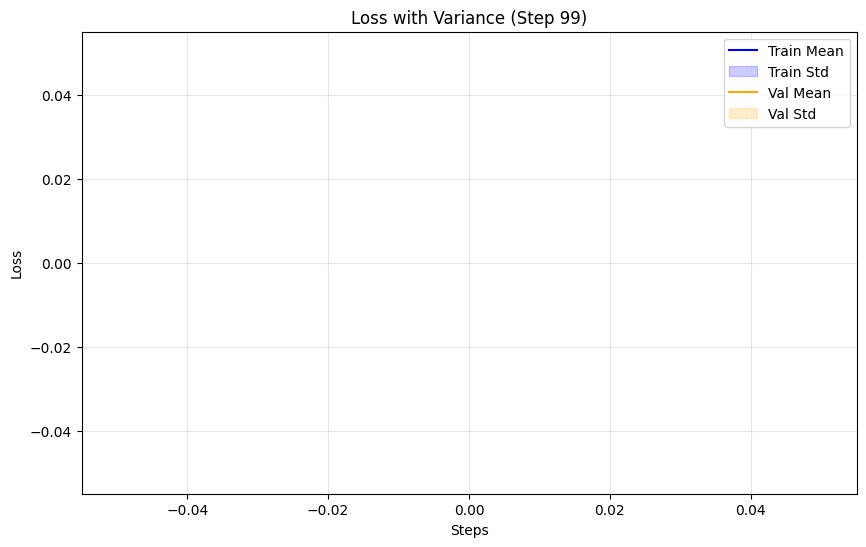

In [9]:
steps = np.array(step_history)
t_mean = np.array(train_history['mean'])
t_std  = np.array(train_history['std'])
v_mean = np.array(val_history['mean'])
v_std  = np.array(val_history['std'])

plt.figure(figsize=(10, 6))

plt.plot(steps, t_mean, label='Train Mean', color='blue')
plt.fill_between(steps, t_mean - t_std, t_mean + t_std, color='blue', alpha=0.2, label='Train Std')

# Plot Validation
plt.plot(steps, v_mean, label='Val Mean', color='orange')
plt.fill_between(steps, v_mean - v_std, v_mean + v_std, color='orange', alpha=0.2, label='Val Std')

plt.title(f'Loss with Variance (Step {epoch})')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optim.state_dict(),
}
torch.save(checkpoint, 'one_layer_transformer.pth')

In [11]:
from torch.nn.functional import cosine_similarity
embedding_weights = model.W_E.weight

def find_closest_words(word, top_n=50):
    word_id = enc.encode(word)
    word_vector = embedding_weights[word_id]
    
    similarities = cosine_similarity(word_vector.unsqueeze(0), embedding_weights)
    
    top_values, top_indices = similarities.topk(top_n + 1)
    
    print(f"\nWords most similar to '{word}':")
    for i in range(1, top_n + 1): # Start at 1 to skip the word itself
        similar_word_id = top_indices[0][i].item()
        print(similar_word_id)
        similar_word = enc.decode([similar_word_id])
        similarity_score = top_values[0][i].item()
        print(f"   - {similar_word}: {similarity_score:.4f}")

find_closest_words("cat", top_n=5)
find_closest_words("love", top_n=5)


Words most similar to 'cat':
36
   - E: 0.0408
44
   - M: 0.0392
164
   - �: 0.0375
259
   - in: 0.0363
27
   - <: 0.0356

Words most similar to 'love':
218
   - : 0.0419
36
   - E: 0.0408
44
   - M: 0.0392
187
   - �: 0.0370
27
   - <: 0.0356


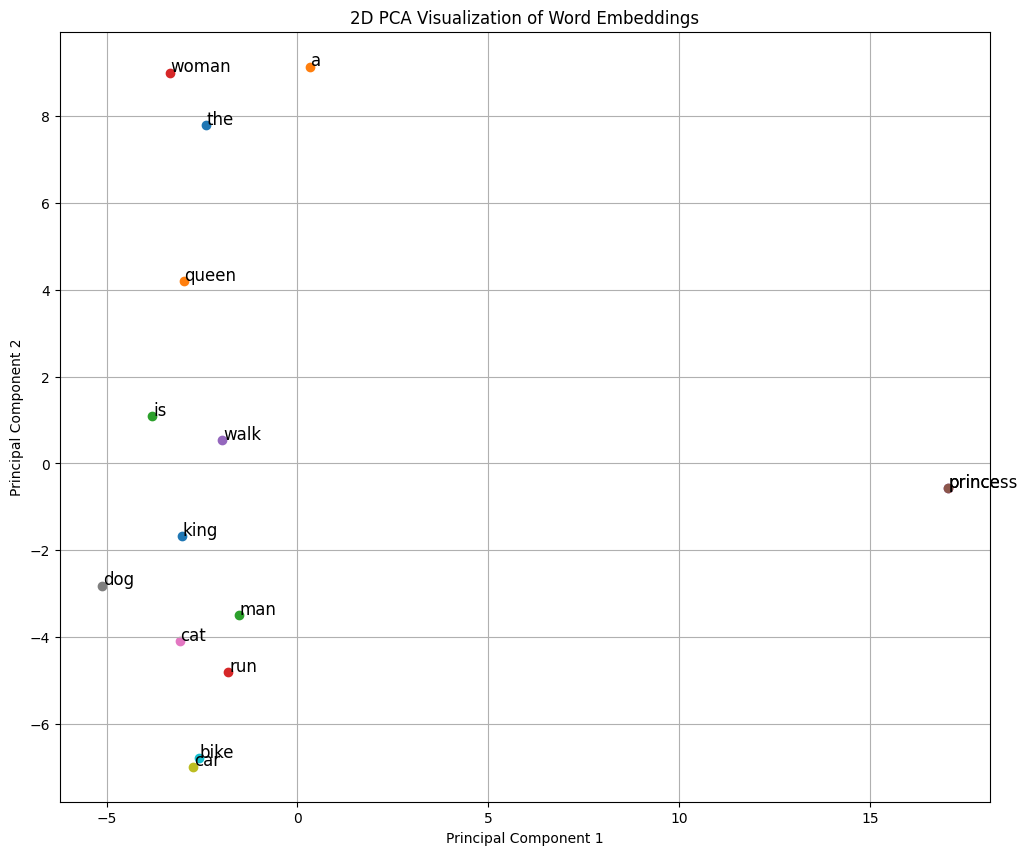

In [12]:
embeddings = model.W_E.weight.detach().cpu().numpy()
vocab_size, d_model = embeddings.shape

all_tokens = [enc.decode([i]) for i in range(vocab_size)]

words_to_track = ["king", "queen", "man", "woman", "prince", "princess", 
                  "cat", "dog", "car", "bike", "the", "a", "is", "run", "walk"]

indices_to_track = [enc.encode(word)[0] for word in words_to_track]

embeddings_subset = embeddings[indices_to_track]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_subset)

plt.figure(figsize=(12, 10))

for i, word in enumerate(words_to_track):
    x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.title("2D PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [13]:
vs = torch.tensor([i for i in range(vocab_size)])
print(f"Original shape: {vs.shape}") # torch.Size([vocab_size])

vs_reshaped = vs.unsqueeze(1) 

print(f"Reshaped tensor shape: {vs_reshaped.shape}") # torch.Size([vocab_size, 1])


model.eval()
model.to('cpu') 

with torch.no_grad(): # Use no_grad for inference to save memory and computation
    logits_ = model(vs_reshaped)

print(f"Final logits shape: {logits_.shape}")

Original shape: torch.Size([50257])
Reshaped tensor shape: torch.Size([50257, 1])
Final logits shape: torch.Size([50257, 1, 50257])


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
        66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
        77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
        88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5,
        99.5]),
 [Text(0, 0.5, 'th'),
  Text(0, 1.5, ' com'),
  Text(0, 2.5, ' G'),
  Text(0, 3.5, 'un'),
  Text(0, 4.5, 'op'),
  Text(0, 5.5, '00'),
  Text(0, 6.5, ' L'),
  Text(0, 7.5, ' not'),
  Text(0, 8.5, 'ess'),
  Text(0, 9.5, ' ex'),
  Text(0, 10.5, ' v'),
  Text(0, 11.5, 'res'),
  Text(0, 12.5, ' E'),
  Text(0, 13.5, 'ew'),

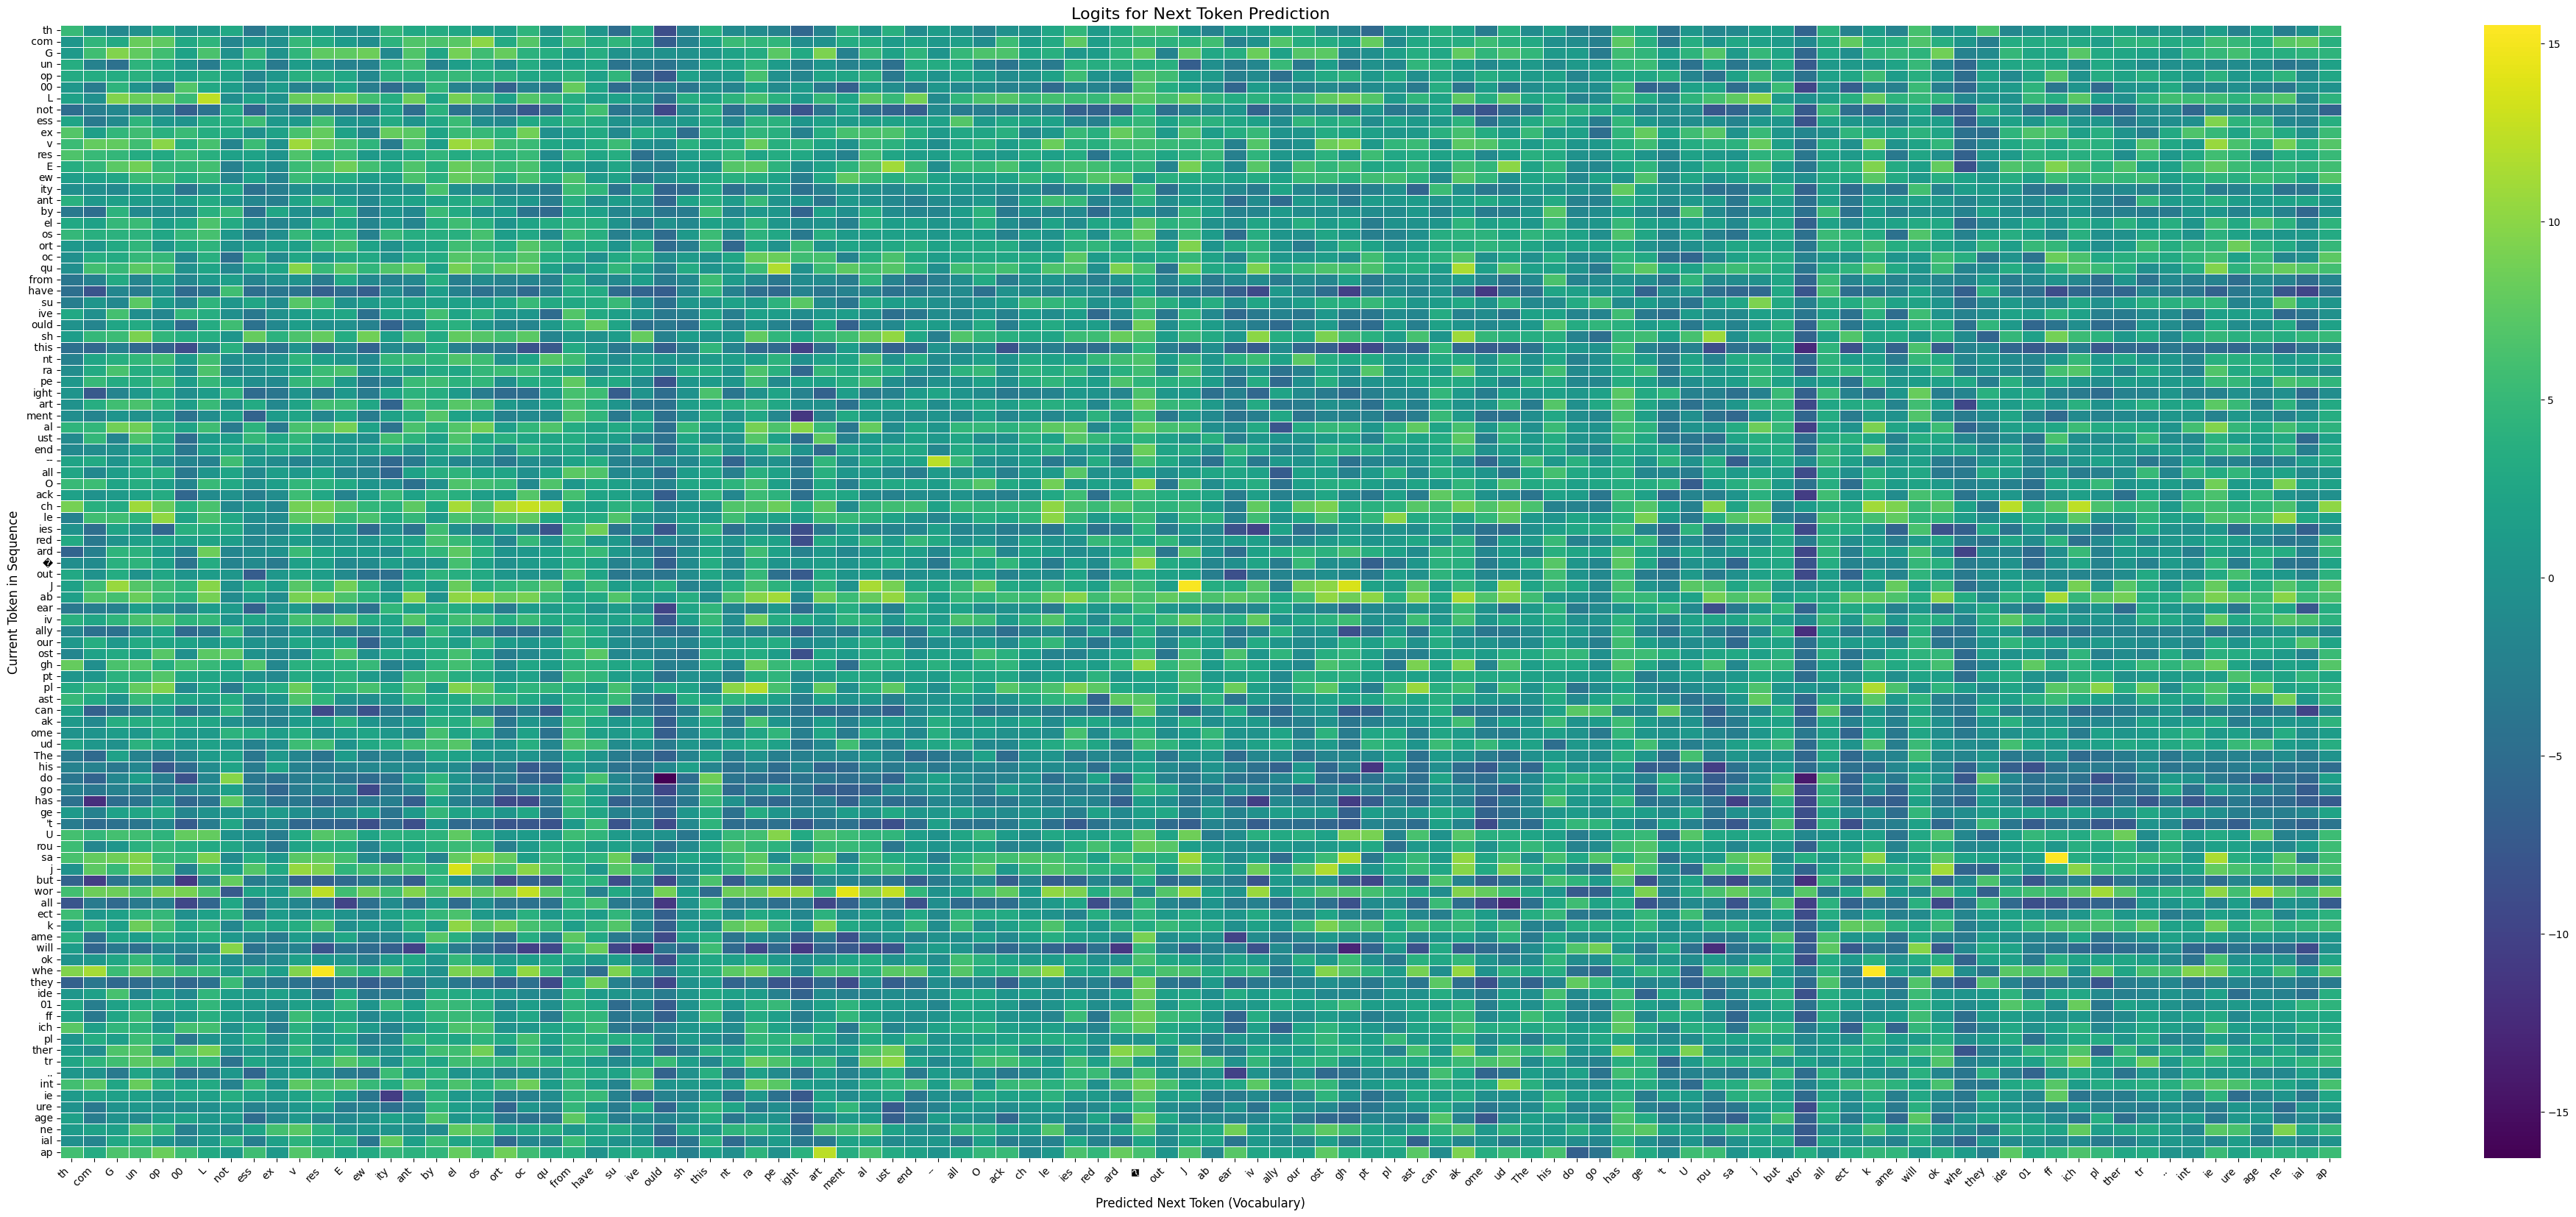

In [14]:
logits_ = logits_.reshape(50257, 50257)
logits_data = logits_.detach().numpy()
plt.figure(figsize=(50, 20))
from_range = 400
range_to_show = from_range + 100
y_labels = x_labels = [enc.decode([i]) for i in range(len(logits_data))]
ax = sns.heatmap(
    logits_data[from_range:range_to_show, from_range:range_to_show], 
    xticklabels=x_labels[from_range:range_to_show],
    yticklabels=y_labels[from_range:range_to_show],
    cmap='viridis',
    linewidths=.5,
)

ax.set_title("Logits for Next Token Prediction", fontsize=16)
ax.set_xlabel("Predicted Next Token (Vocabulary)", fontsize=12)
ax.set_ylabel("Current Token in Sequence", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

In [15]:
max_data = np.argmax(logits_data, axis=1)

with open("next_token_predictions.txt", "w", encoding="utf-8") as f:
    for e, i in enumerate(max_data):
        f.write(f"start: '{enc.decode([e])}', next: '{enc.decode([i])}'\n")

In [16]:
def sample_from_model(model, start_text, encoder, max_new_tokens, temperature=1.0, top_k=50):
    model.eval()
    model.to(device)

    start_tokens = encoder.encode(start_text)
    idx = torch.tensor(start_tokens, dtype=torch.long, device=device)
    if idx.dim() == 1:
        idx = idx.unsqueeze(0) 

    for _ in range(max_new_tokens):
        logits = model(idx)
        logits = logits[:, -1, :] 
        
        if temperature != 0:
            logits = logits / temperature

        if top_k is not None:
            top_logits, top_idx = torch.topk(logits, top_k, dim=-1)
            logits_filtered = torch.full_like(logits, float('-inf'))
            logits_filtered.scatter_(1, top_idx, top_logits)
            logits = logits_filtered

        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1)
        
        idx = torch.cat((idx, next_idx), dim=1)
        
    generated_tokens = idx.squeeze(0).cpu().numpy()
    return encoder.decode(generated_tokens)

In [17]:
start_prompt = """Hello world! """
generated_text = sample_from_model(
    model=model,
    start_text=start_prompt,
    encoder=enc,
    max_new_tokens=100,
    temperature=0.2,
    top_k=100
)

print("\n--- Generated Text ---")
print(generated_text)


--- Generated Text ---
Hello world! сто

The first-ever, the first-team-year-old boy, the first-ever-old boy, and the first-ever-team-year-old boy, and the other hand-to-face-to-the-right-of-the-scenes-based-level-old-the-top-of-the-top-of-the-right-the-family-based-up-to-date-the-top-


In [18]:
def test_prompt(model, start_text, encoder, test_sample, temperature=0):
    model.eval()
    model.to(device)

    start_tokens = encoder.encode(start_text)
    idx = torch.tensor(start_tokens, dtype=torch.long, device=device)
    if idx.dim() == 1:
        idx = idx.unsqueeze(0) 

    logits = model(idx)
    logits = logits[0, -1, :] 
    
    if temperature != 0:
        logits = logits / temperature

    probs = F.softmax(logits, dim=-1)
    p = probs.reshape(-1).cpu()
    v = logits.reshape(-1).cpu()

    sorted_values, original_indices = torch.sort(p, descending=True)
        
    scaled_values = sorted_values * 100
    formatted_values = [f"{val:.3f}" for val in scaled_values]
    decoded_test_token = enc.encode(test_sample)[0]

    print(p[decoded_test_token])
    print("Token | Value (%)")
    print("---------------------")
    for i,(idx, val_str) in enumerate(zip(original_indices, formatted_values)):
        decoded_token = enc.decode([idx.item()])
        if i < 9:
            print(f"Top {i}th token. | Logits: {v[idx].item():.3f},  Probs: {val_str:<3}% | Token: {decoded_token:<20}")
        if idx == decoded_test_token:
            print(f"Top {i}th token. | Logits: {v[idx].item():.3f},  Probs: {val_str:<3}% | Token: {decoded_token:<20}")

    return probs, logits

In [54]:
probs, values = test_prompt(model, "She refused Shevardino, unless they gained everybody shouted Shevardino. Shevardino. ", enc, 'Shevardino.')

tensor(0.0001, grad_fn=<SelectBackward0>)
Token | Value (%)
---------------------
Top 0th token. | Logits: 7.625,  Probs: 3.787% | Token: vern                
Top 1th token. | Logits: 7.498,  Probs: 3.336% | Token: ich                 
Top 2th token. | Logits: 6.684,  Probs: 1.477% | Token: urch                
Top 3th token. | Logits: 6.573,  Probs: 1.322% | Token: iced                
Top 4th token. | Logits: 6.496,  Probs: 1.224% | Token: �                   
Top 5th token. | Logits: 6.431,  Probs: 1.148% | Token: �                   
Top 6th token. | Logits: 6.142,  Probs: 0.860% | Token: ????                
Top 7th token. | Logits: 6.101,  Probs: 0.825% | Token: ét                  
Top 8th token. | Logits: 6.040,  Probs: 0.776% | Token: urn                 
Top 1035th token. | Logits: 1.895,  Probs: 0.012% | Token: She                 


In [55]:
input_text = "He refused, unless they gained everybody shouted Shevardino. Shevardino. Shevardino. "
tokens = enc.encode(input_text)
input_tensor = torch.tensor(tokens).unsqueeze(0)
input_tensor= input_tensor.to(device)

model.eval()
model.to(device)
with torch.no_grad():
    logits, qk_scores, attention_pattern, v_output, z_output, hidden_state = model(input_tensor, return_all=True)


In [56]:
def plot_attention_heads(qk_scores, tokens, figsize=(15, 12)):
    """
    qk_scores: Tensor of shape (batch, num_heads, seq_len, seq_len)
    tokens: List of strings matching the seq_len
    """
    if torch.is_tensor(qk_scores):
        qk_scores_np = qk_scores.detach().cpu().numpy()
    else:
        qk_scores_np = qk_scores
    
    # Validation
    batch, num_heads, seq_len, _ = qk_scores_np.shape
    if len(tokens) != seq_len:
        print(f"Warning: Token list length ({len(tokens)}) does not match sequence length ({seq_len})")
        # Truncate or pad tokens to match to prevent crash
        tokens = tokens[:seq_len] 

    # Calculate grid size (e.g. for 12 heads, do 3x4 or 4x3)
    rows = int(np.ceil(num_heads / 4))
    cols = min(num_heads, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    # Flatten axes array for easy iteration if it's multidimensional
    if num_heads > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
        
    fig.suptitle('Attention Patterns (Darker = Higher Attention)', fontsize=16)
    
    # Generate distinct colors for each head
    base_colors = plt.cm.tab20(np.linspace(0, 1, num_heads))
    decodeds = [enc.decode([i]) for i in tokens]
    for i in range(num_heads):
        ax = axes[i]
        
        # Create a custom colormap from White -> Head Color
        cmap = LinearSegmentedColormap.from_list(
            f'custom_cmap_{i}', 
            [(1, 1, 1, 0), base_colors[i]], 
            N=256
        )

        
        # Draw Heatmap
        sns.heatmap(
            qk_scores_np[0, i, :, :], 
            cmap=cmap,
            ax=ax,
            cbar=True,
            xticklabels=decodeds, # <--- PUT TOKENS ON X
            yticklabels=decodeds, # <--- PUT TOKENS ON Y
            vmin=0, 
            vmax=np.max(qk_scores_np[0, i, :, :])
        )
        
        ax.set_title(f'Head {i}')
        # Rotate labels so they don't overlap
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
        
    plt.tight_layout()
    return fig

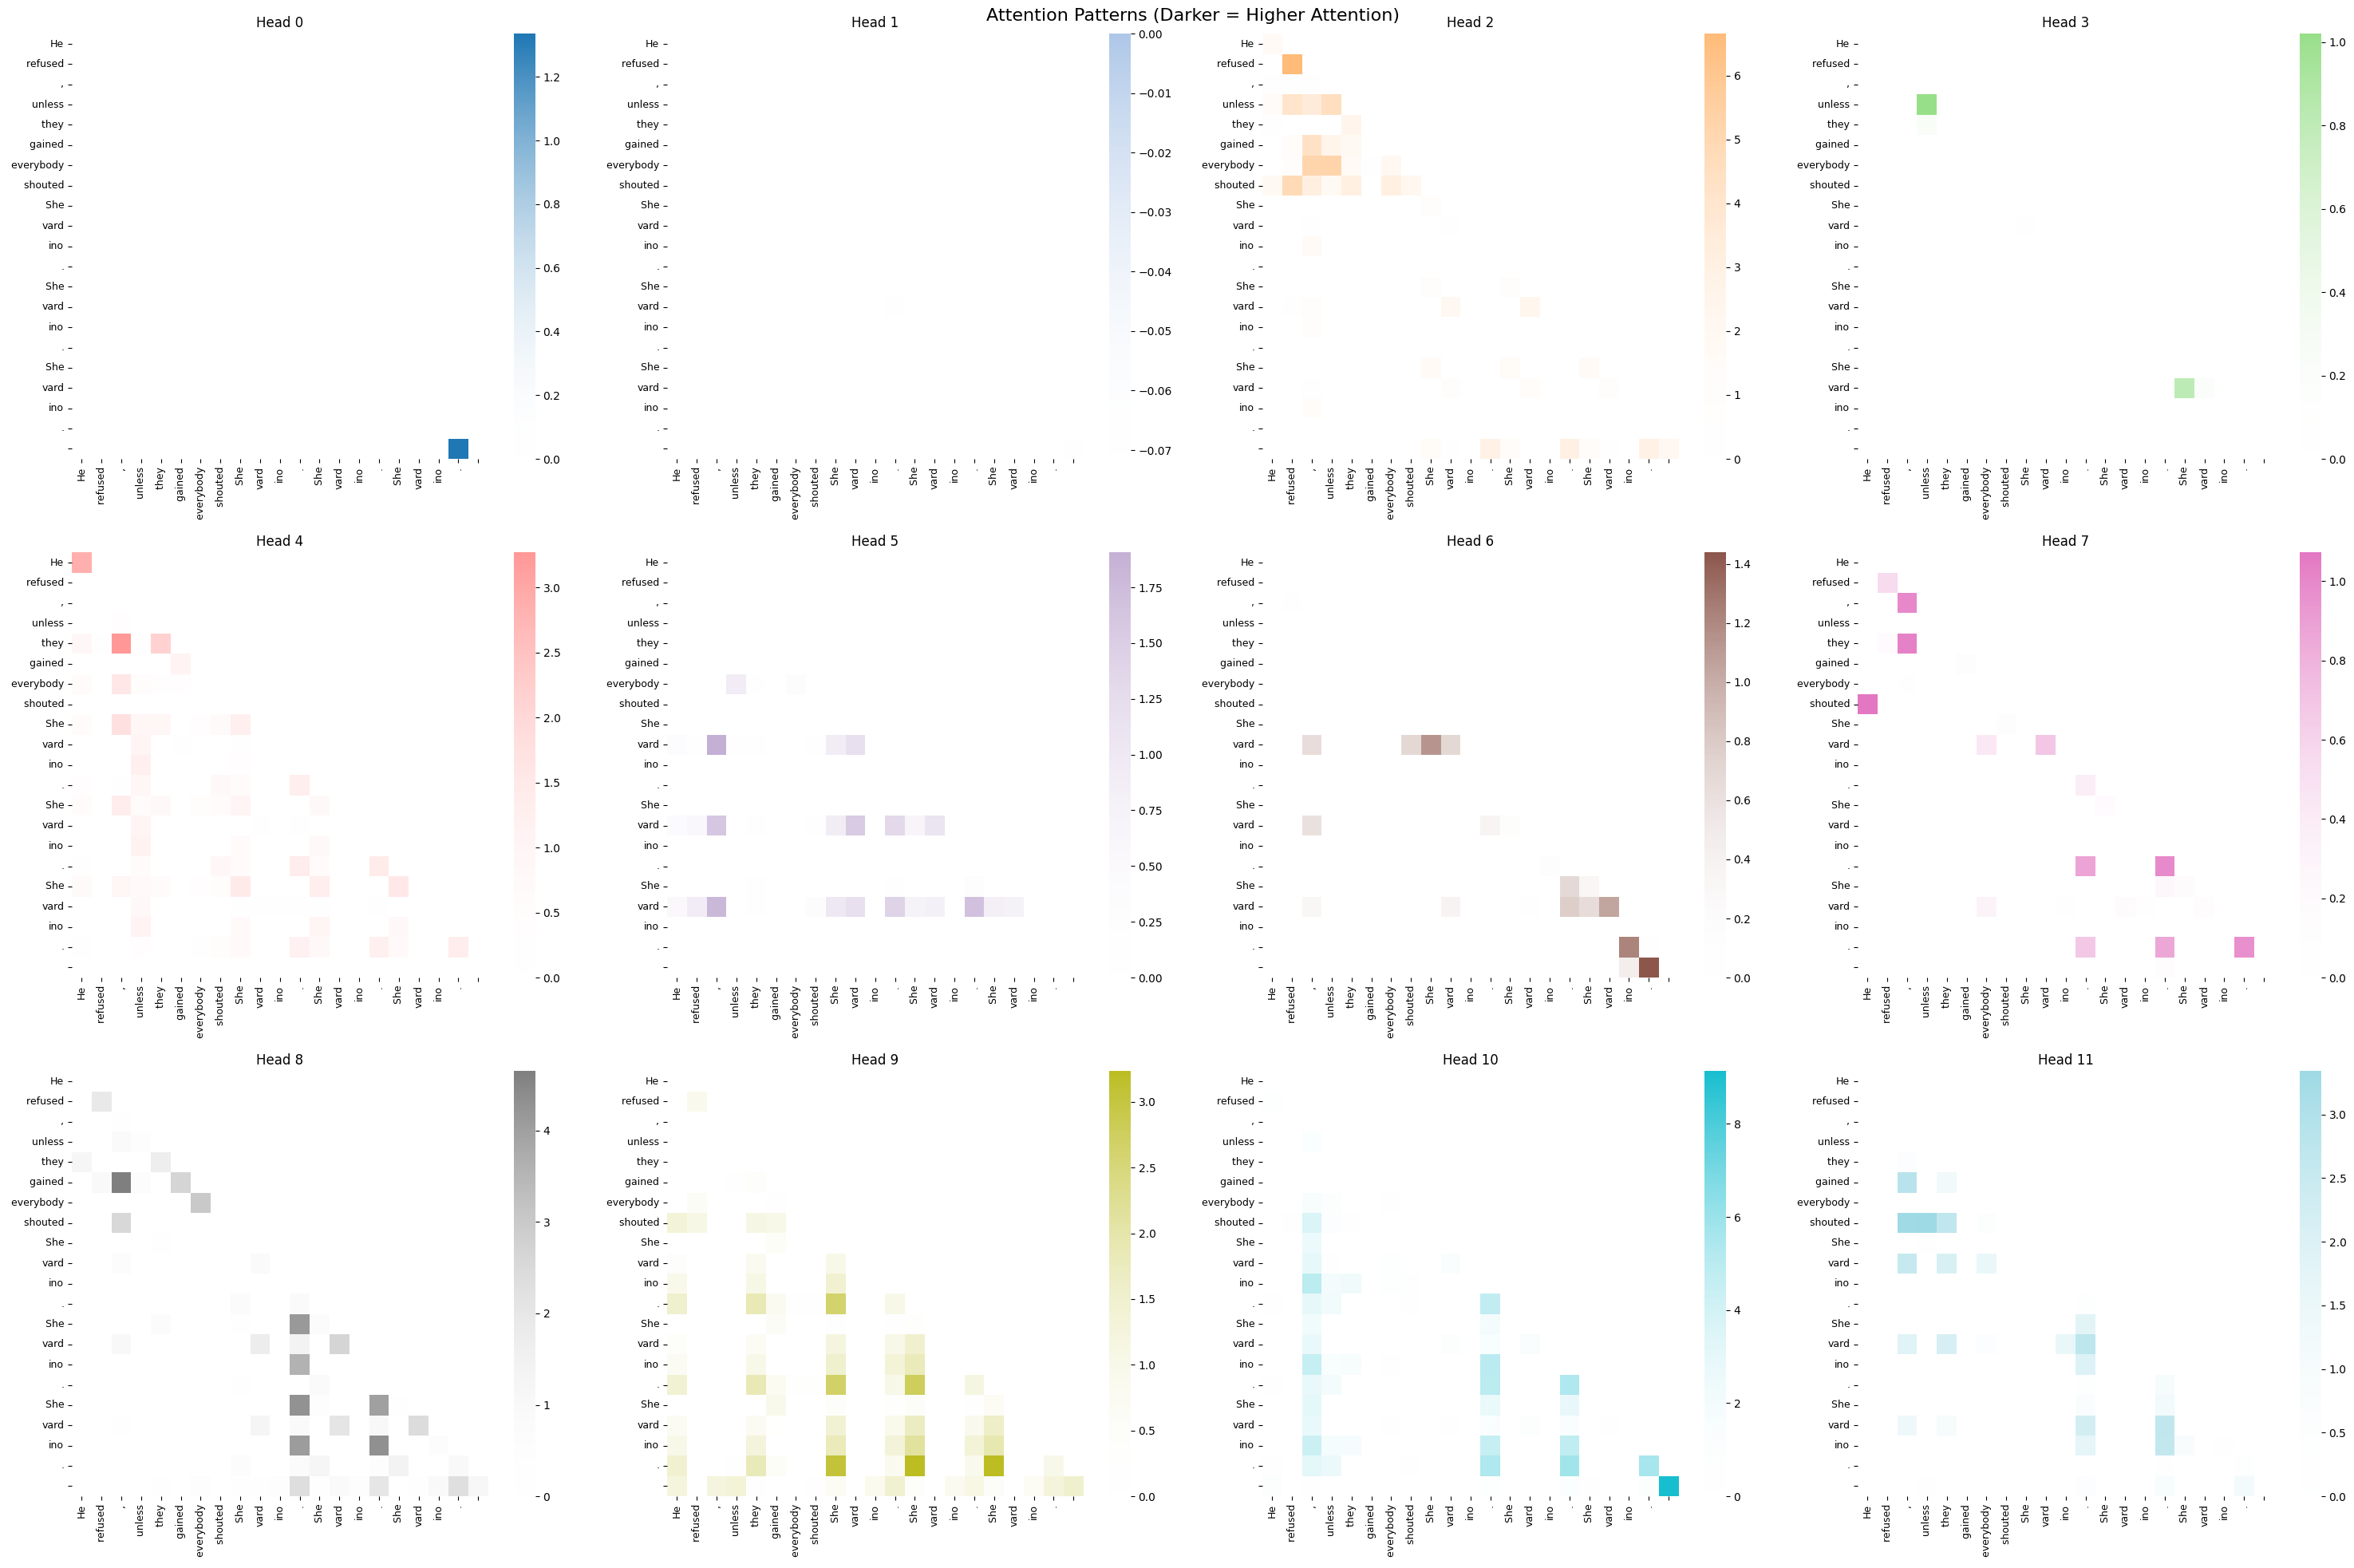

In [57]:
fig = plot_attention_heads(qk_scores,tokens, (30, 20))
plt.show()

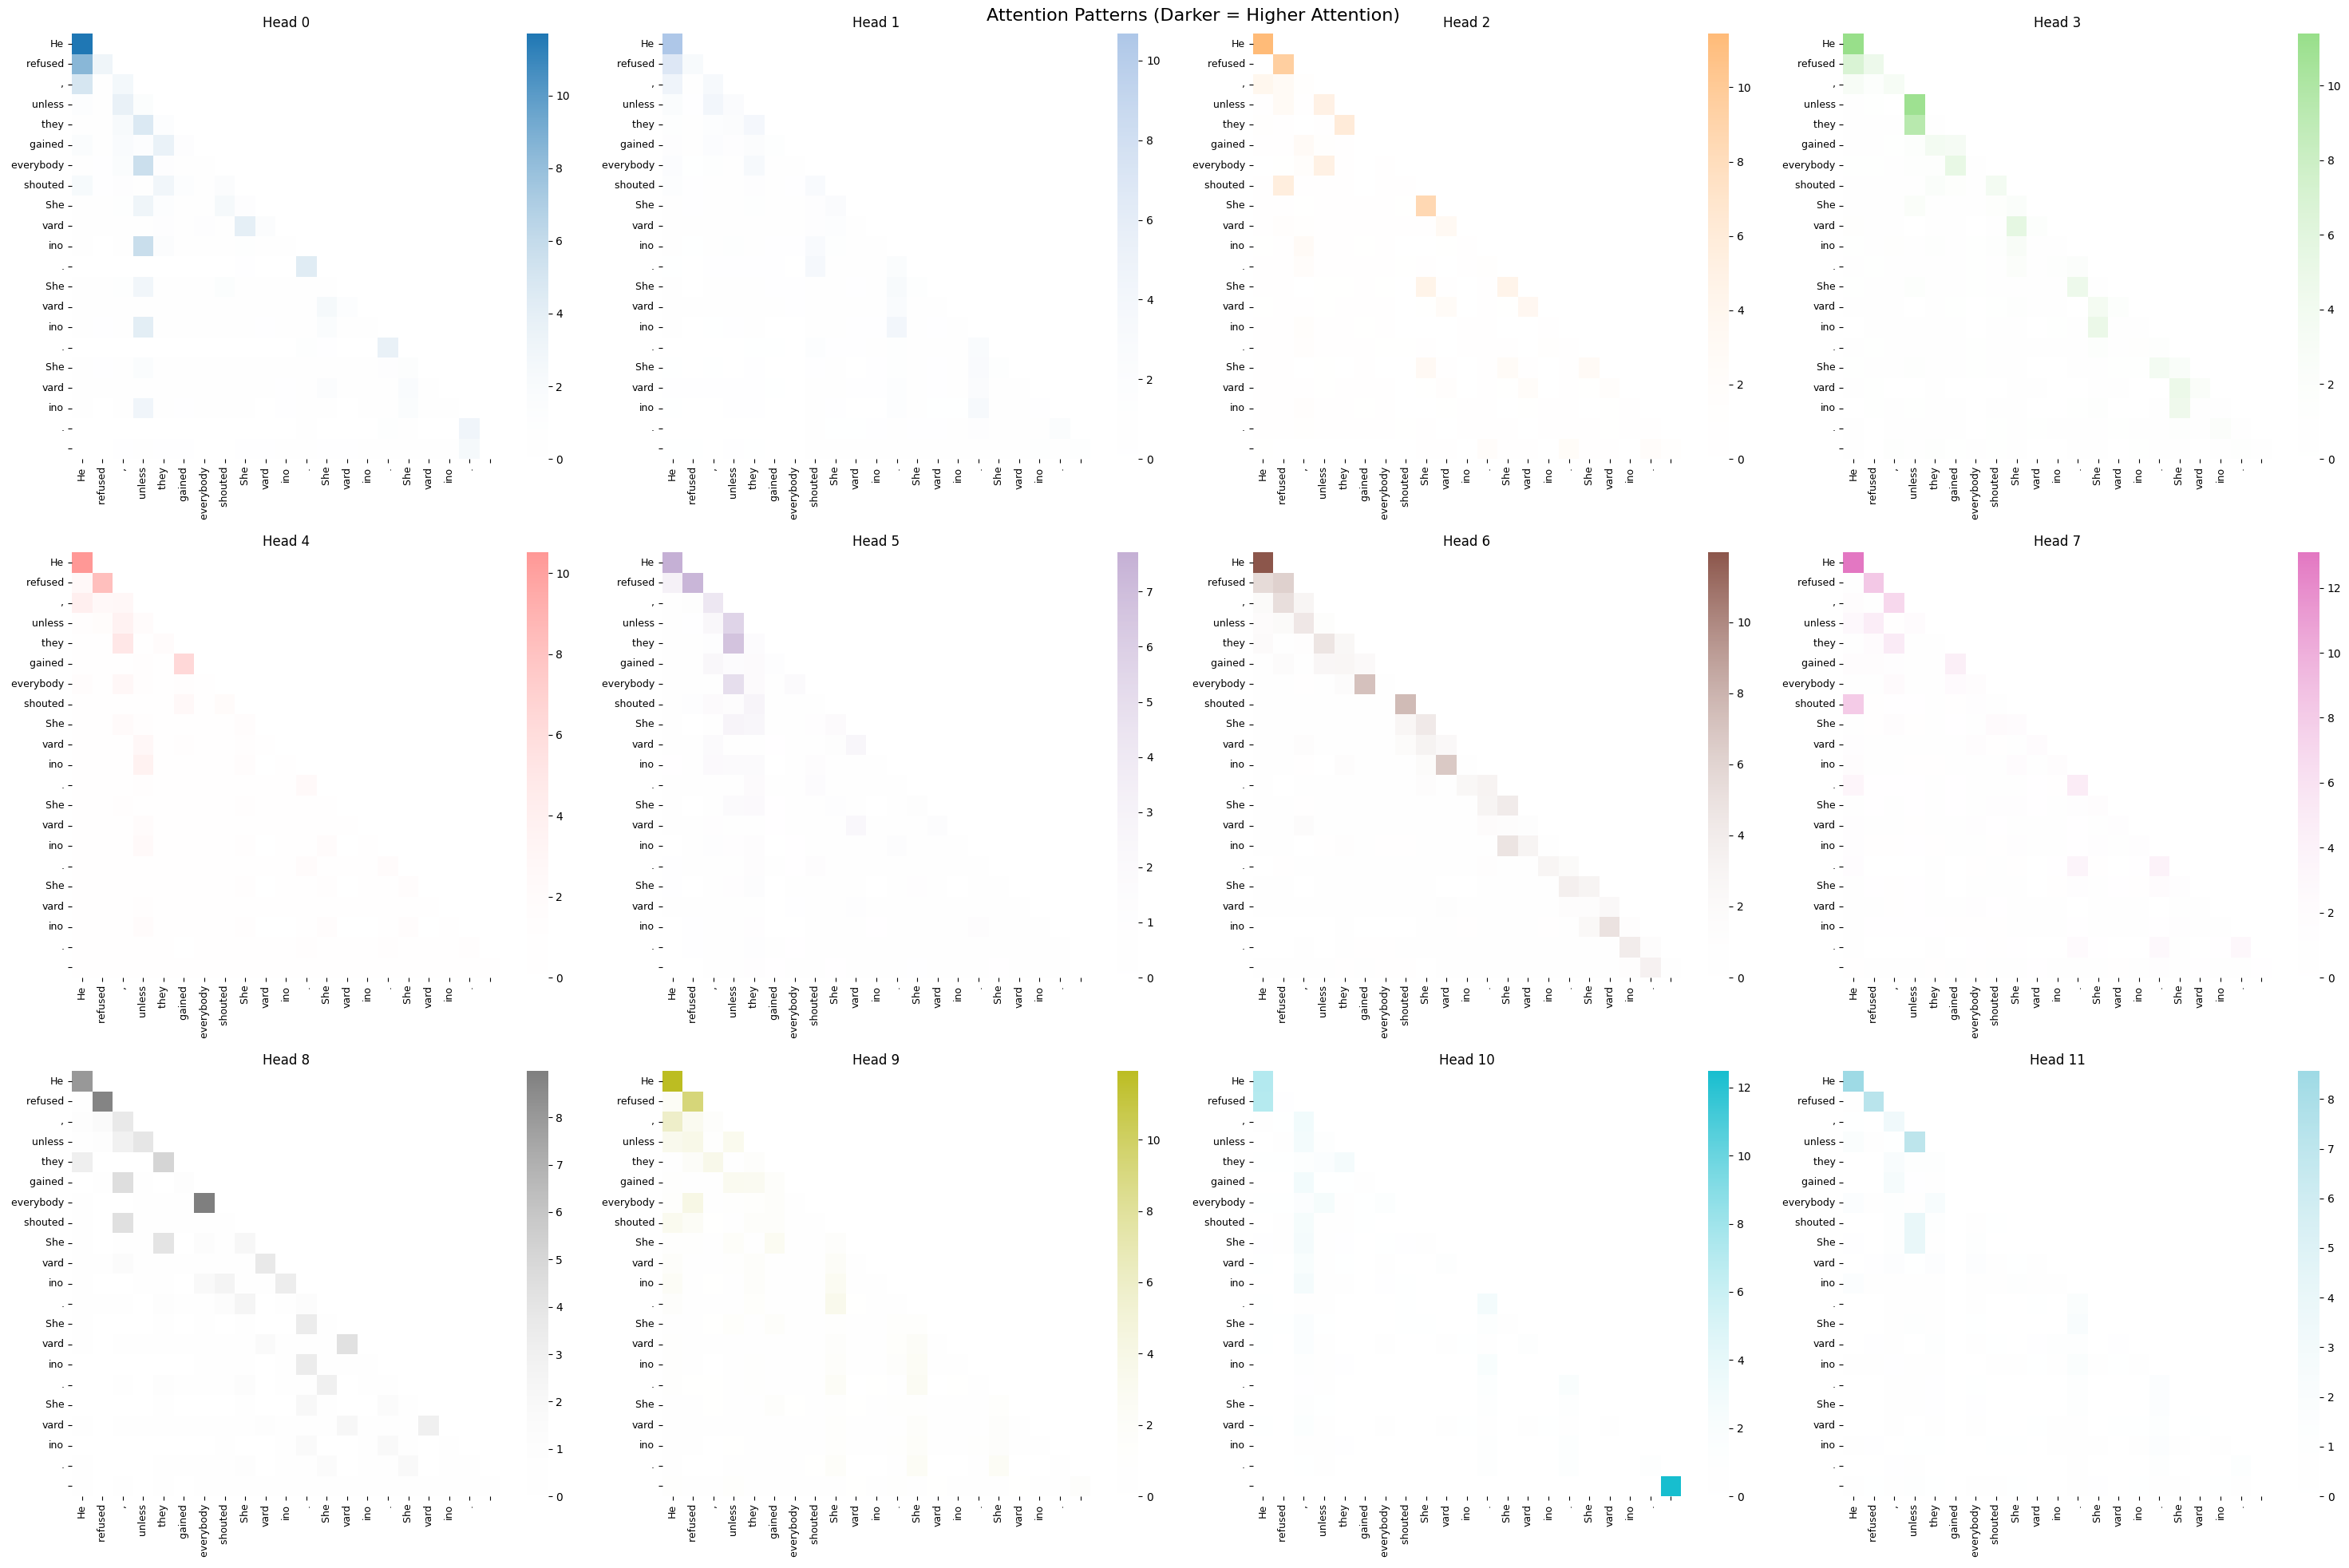

In [58]:
v_norms = torch.norm(v_output, p=2, dim=-1)
v_norms_expanded = v_norms.unsqueeze(-2)
weighted_contributions = attention_pattern * v_norms_expanded

fig = plot_attention_heads(weighted_contributions, tokens, (30, 20))
plt.show()

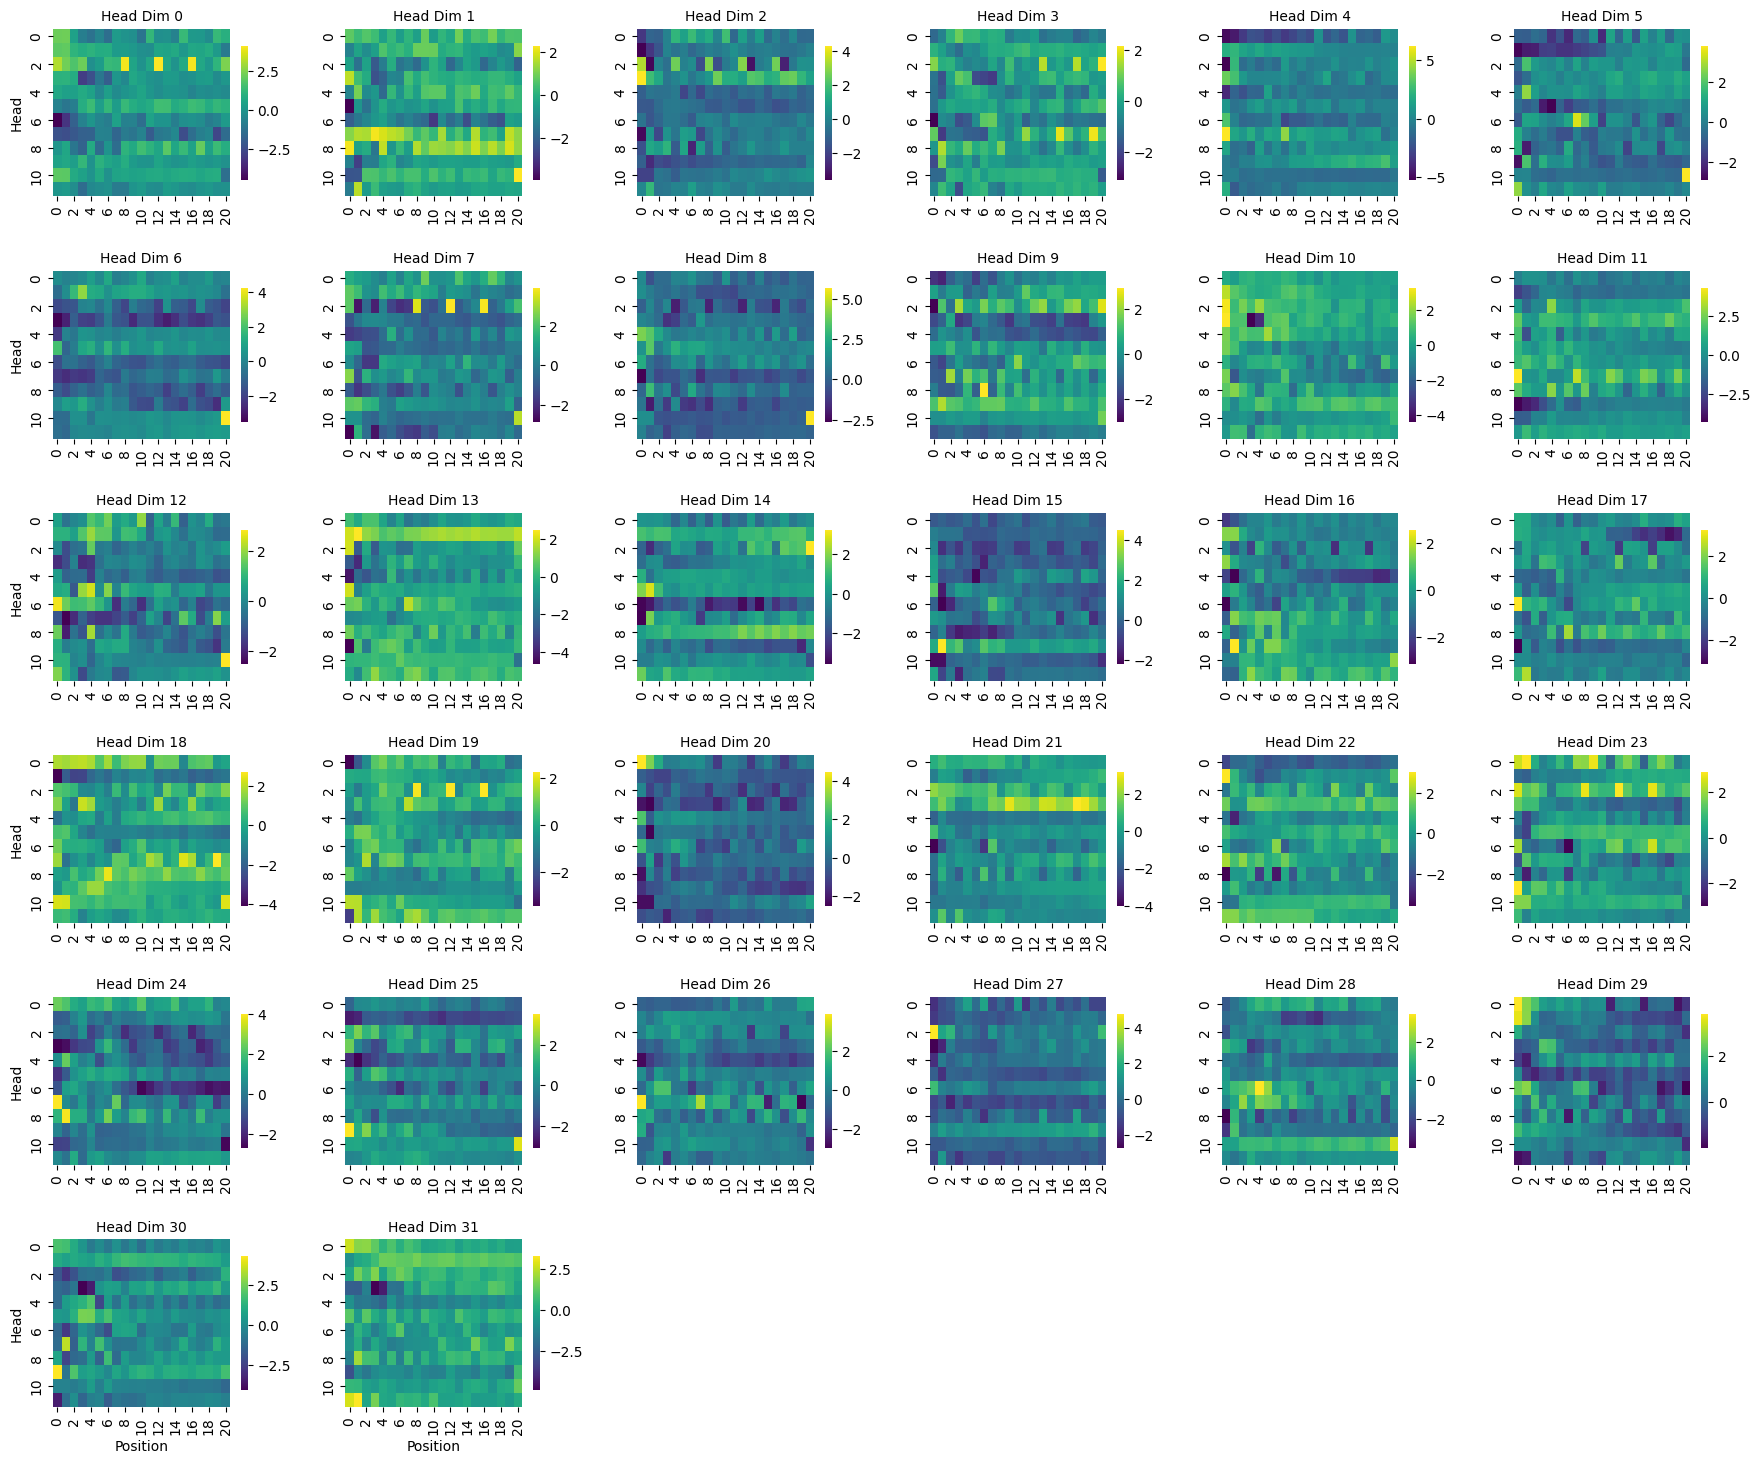

In [62]:
def visualize_attention_dimensions(z_output, n_heads, d_head, dimensions_to_show=None):
    # Reshape to [batch_size, seq_len, n_heads, d_head]
    reshaped = z_output.cpu().numpy().reshape(z_output.shape[0], z_output.shape[1], n_heads, d_head)

    # Default to showing all dimensions if not specified
    if dimensions_to_show is None:
        dimensions_to_show = list(range(d_head))

    n_dims_to_show = len(dimensions_to_show)
    if n_dims_to_show == 0:
        print("No dimensions to show.")
        return None

    # --- Key Change: Calculate grid size (rows, cols) ---
    n_cols = int(np.ceil(np.sqrt(n_dims_to_show)))
    n_rows = int(np.ceil(n_dims_to_show / n_cols))

    # --- Key Change: Create a grid of subplots ---
    # Adjust figure size dynamically based on the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    # Flatten the 2D axes array into a 1D array for easy iteration
    # This handles cases where n_rows or n_cols is 1
    axes = axes.flatten() if n_dims_to_show > 1 else [axes]

    for i, dim in enumerate(dimensions_to_show):
        ax = axes[i]
        sns.heatmap(
            reshaped[0, :, :, dim].T,  # Transpose to have heads on y-axis
            ax=ax,
            cmap='viridis',
            cbar=True,
            cbar_kws={"shrink": 0.8} # Make colorbars a bit smaller
        )
        ax.set_title(f'Head Dim {dim}', fontsize=10)

        # --- Improvement: Place labels only on the edges for clarity ---
        # Set y-label (Head) only for the first column
        if i % n_cols == 0:
            ax.set_ylabel('Head')
        else:
            ax.set_ylabel('')
        
        # Set x-label (Position) only for the bottom row
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel('Position')
        else:
            ax.set_xlabel('')

    # --- Key Change: Hide any unused subplots in the grid ---
    for i in range(n_dims_to_show, n_rows * n_cols):
        axes[i].axis('off')

    plt.tight_layout(pad=2.0) # Add padding to prevent title overlap
    return fig

fig_all = visualize_attention_dimensions(z_output, n_heads, d_head)
plt.show()

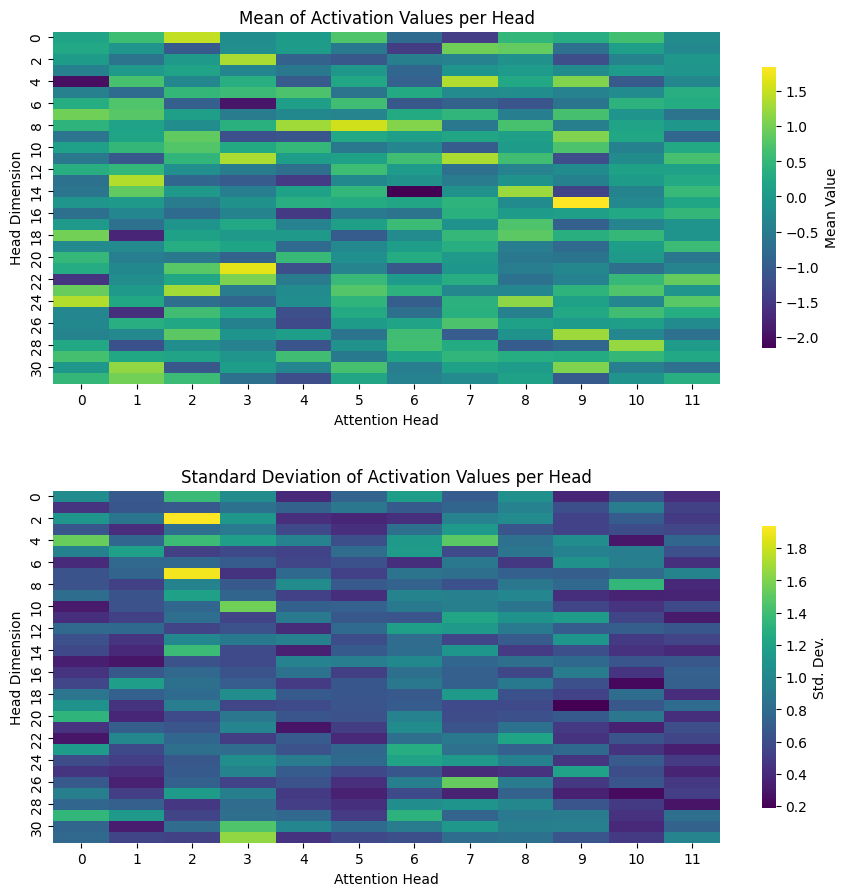

In [61]:
def visualize_head_statistics(z_output, n_heads, d_head):
    # Reshape to [batch_size, seq_len, n_heads, d_head]
    reshaped = z_output.cpu().numpy().reshape(z_output.shape[0], z_output.shape[1], n_heads, d_head)
    
    mean_values = np.mean(reshaped[0], axis=0)
    std_values = np.std(reshaped[0], axis=0)
    
    fig_width = max(8, n_heads * 0.8)
    fig_height_per_plot = max(4, d_head * 0.15)
    fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height_per_plot * 2))
    
    sns.heatmap(
        mean_values.T, 
        ax=axes[0], 
        cmap='viridis', 
        cbar_kws={"shrink": 0.8, "label": "Mean Value"}
    )
    axes[0].set_title('Mean of Activation Values per Head')
    axes[0].set_xlabel('Attention Head')
    axes[0].set_ylabel('Head Dimension')
    
    # Plot Standard Deviation
    sns.heatmap(
        std_values.T, 
        ax=axes[1], 
        cmap='viridis', 
        cbar_kws={"shrink": 0.8, "label": "Std. Dev."}
    )
    axes[1].set_title('Standard Deviation of Activation Values per Head')
    axes[1].set_xlabel('Attention Head')
    axes[1].set_ylabel('Head Dimension')
    
    plt.tight_layout(pad=3.0) # Add padding to prevent title/label overlap
    return fig

fig = visualize_head_statistics(z_output, n_heads, d_head)
plt.show()